### Centro Universitário Senac  
**Professor**: **Rafael Cóbe (raphaelmcobe@gmail.com)**  
**Disciplina**: Introdução ao Aprendizado de Máquina  

### Projeto - **Detecção de fraudes em transações de Cartão de Crédito**

### Autores
**Renato Calabro (calabro@live.com)**
**Ágata Oliveira (agata.aso@hotmail.com)**
**Lucas Parisi (parisi.lucas@gmail.com)**
**Douglas Carvalho Rocha (douglas.particular@gmail.com)**
**Angel Guillermo Morales Romero (aguilhermemr@gmail.com)**

### Descrição

É importante que as empresas de cartão de crédito sejam capazes de reconhecer transações
fraudulentas com cartão de crédito para que os clientes não sejam cobrados por itens que não
compraram.
Esse conjunto de dados está disponível após passar pelo algoritmo PCA. Isso garante o
anonimato.
Nesse projeto, o maior desafio será lidar com classes desbalanceadas. Aqui podem ser
utilizadas uma gama de algoritmos para análise de dados, além de estratégias para otimização
de hiperparâmetros e combinação de classificadores.

### Considerações sobre PCA

- PCA (Principal Component Analysis) transforma variáveis originais em combinações lineares ortogonais, maximizando a variância explicada.
- As componentes PCA:
  - São centradas e padronizadas (média ≈ 0).
  - Perdem interpretabilidade direta.
  - Estão ordenadas por importância (V1 > V2 > ... > V28).
- Portanto, **transformações adicionais sobre componentes PCA (ex: log, minmax)** **não são recomendadas**.

In [ ]:
!../.venv/bin/python --version
%pip install -r ../requirements.txt

In [3]:
from pathlib import Path
import pandas as pd
from pathlib import Path
import joblib

from scipy.io import arff

base_path = Path("../datasets/credit-card-fraud")
models_path = Path("./models")



### Sobre os dados - CreditCardFraudDetection

Ref: https://www.openml.org/search?type=data&sort=runs&id=42175&status=active

É importante que as empresas de cartão de crédito consigam reconhecer transações fraudulentas para que os clientes não sejam cobrados por itens que não compraram.

#### Conteúdo

O conjunto de dados contém transações realizadas com cartões de crédito em setembro de 2013 por portadores de cartão europeus. O dataset apresenta transações que ocorreram ao longo de dois dias, nas quais foram identificadas 492 fraudes entre 284.807 transações. O conjunto é altamente desbalanceado: a classe positiva (fraudes) representa apenas 0,172% de todas as transações.

Ele contém apenas variáveis numéricas como entrada, que são resultado de uma transformação via PCA. Infelizmente, por questões de confidencialidade, não podemos fornecer as variáveis originais nem mais informações de contexto sobre os dados. As variáveis `V1`, `V2`, ..., `V28` são os componentes principais obtidos via PCA; as únicas variáveis que **não** foram transformadas são `Time` e `Amount`. 

- A variável `Time` representa o tempo (em segundos) decorrido desde a primeira transação do dataset.
- A variável `Amount` representa o valor da transação, podendo ser usada em estratégias de aprendizado sensível a custo.
- A variável `Class` é a variável alvo, assumindo o valor 1 em caso de fraude e 0 caso contrário.

#### Inspiração

Identificar transações fraudulentas com cartão de crédito.

Dado o desequilíbrio entre as classes, recomenda-se avaliar o desempenho usando a métrica **Área sob a Curva Precisão-Revocação (AUPRC)**. A acurácia da matriz de confusão não é significativa nesse cenário de classificação desbalanceada.

---

In [4]:
ratings_file = base_path / "dataset.arff"

data, meta = arff.loadarff(ratings_file)

raw_data = pd.DataFrame(data)
for col in raw_data.select_dtypes([object]):
    raw_data[col] = raw_data[col].str.decode('utf-8')

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt

In [6]:
X = raw_data.drop(columns=["Class"])
y = raw_data["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

metrics = ["precision", "f1", "roc_auc", "average_precision"]

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("power", PowerTransformer(standardize=True), ["V28", "Amount"]),
    ],
    remainder="passthrough"
)

def create_pipeline(model, preprocessor=preprocessor):
    return Pipeline([
        ("preprocessing", preprocessor),
        ("clf", model)
    ])

display_labels=["0 - Legítimo", "1 - Fraude"]

In [8]:
def plot_threshold_metrics(model, X, y_true, title_prefix=""):
    y_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)


    precision, recall, f1 = [], [], []
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        precision.append(precision_score(y_true, y_pred_t, zero_division=0))
        recall.append(recall_score(y_true, y_pred_t, zero_division=0))
        f1.append(f1_score(y_true, y_pred_t, zero_division=0))

    # Plot
    plt.figure(figsize=(14, 6))

    # Precision
    plt.plot(thresholds, precision, label='Precision', marker='o')
    for i, t in enumerate(thresholds):
        plt.annotate(f"{t:.2f}", (thresholds[i], precision[i]), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    # Recall
    plt.plot(thresholds, recall, label='Recall', marker='o')
    for i, t in enumerate(thresholds):
        plt.annotate(f"{t:.2f}", (thresholds[i], recall[i]), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    # F1 Score
    plt.plot(thresholds, f1, label='F1 Score', marker='o')
    for i, t in enumerate(thresholds):
        plt.annotate(f"{t:.2f}", (thresholds[i], f1[i]), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{title_prefix}Precision, Recall e F1 vs Threshold (via ROC Curve)")
    plt.legend()
    plt.grid(True)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

In [9]:
def predict_with_threshold(model, X, threshold: float = 0.5):
    y_proba = model.predict_proba(X)[:, 1]
    return (y_proba >= threshold).astype(int)

### Ajuste de Threshold e Justificativa

Para otimizar a detecção de fraudes, foi realizada uma análise visual das métricas de desempenho (Precision, Recall e F1 Score) em função dos thresholds de decisão. O objetivo foi encontrar o ponto de corte ideal para transformar as probabilidades previstas pelos modelos em classes (fraude ou legítimo), com foco na redução dos falsos negativos.

##### Etapas do Processo:

1. **Geração das curvas** de Precision, Recall e F1 Score com base nos thresholds extraídos da `roc_curve`, que fornece uma resolução mais refinada e aderente ao comportamento do classificador.
2. **Análise visual das curvas**, observando a região em que:
   - O F1 Score atinge seu valor máximo.
   - Precision e Recall se estabilizam ou convergem.
3. **Escolha do threshold ótimo**, priorizando o equilíbrio entre sensibilidade (Recall) e especificidade (Precision). O ponto selecionado apresentou:
   - **Alta precisão**, para evitar alarmes falsos (falsos positivos).
   - **Alto recall**, essencial para garantir que a maior parte das fraudes reais seja identificada.
   - **F1 Score elevado**, indicando bom equilíbrio entre as duas métricas.

##### Justificativa:

Em contextos de **fraude financeira**, a consequência de deixar passar uma fraude (falso negativo) é muito mais grave do que gerar uma falsa suspeita (falso positivo). Por isso, o **threshold padrão (0.5)** pode não ser o mais adequado, já que não leva em conta o custo dos erros de classificação.

Ao utilizar a análise das curvas, foi possível **ajustar o threshold para um ponto em que o modelo é mais sensível à detecção de fraudes**, sem comprometer excessivamente a precisão. Essa abordagem contribui para um sistema de detecção mais robusto, alinhado com os objetivos do negócio e as exigências operacionais.



#### Random Forest

Melhores parâmetros: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_leaf_nodes': 50}


In [10]:
rf_model_name = "fraud_pipeline_rf-gini-depth10-leaf50-powertransform-v1.joblib"
rf_model_file = models_path / rf_model_name

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(
    random_state=42, 
    n_estimators=10,
    criterion="gini",
    max_depth=10,
    max_leaf_nodes=50,
    n_jobs=-1
)

rf_pipeline = create_pipeline(rf_final, preprocessor)

display(rf_pipeline.fit(X_train, y_train))
joblib.dump(rf_pipeline, rf_model_file)

/home/rcalabro/codebase/senac-ia/machine-learning/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power', PowerTransformer(),
                                                  ['V28', 'Amount'])])),
                ('clf',
                 RandomForestClassifier(max_depth=10, max_leaf_nodes=50,
                                        n_estimators=10, n_jobs=-1,
                                        random_state=42))])

['models/fraud_pipeline_rf-gini-depth10-leaf50-powertransform-v1.joblib']

In [11]:
rf_pipeline = joblib.load(rf_model_file)

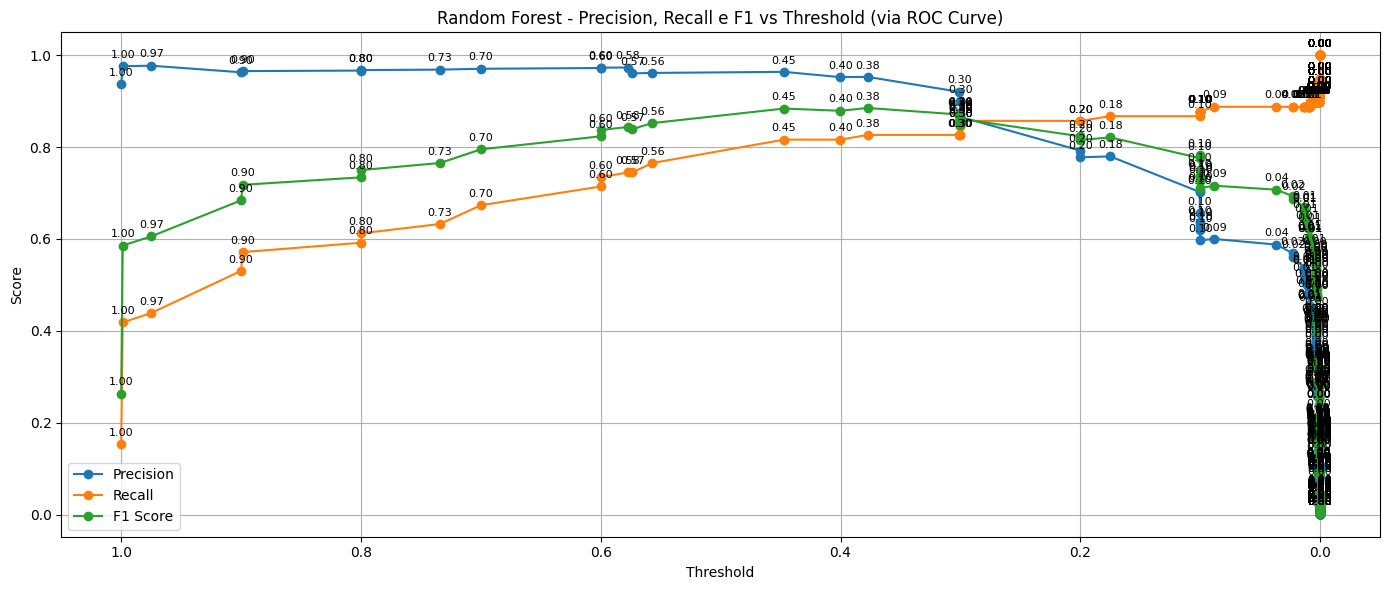

In [42]:
plot_threshold_metrics(rf_pipeline, X_test, y_test, title_prefix="Random Forest - ")

In [23]:
rf_threshold = 0.30 # análise visual
rf_y_pred = predict_with_threshold(rf_pipeline, X_test, rf_threshold)
rf_y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

'PR AUC (Average Precision): 0.8520'

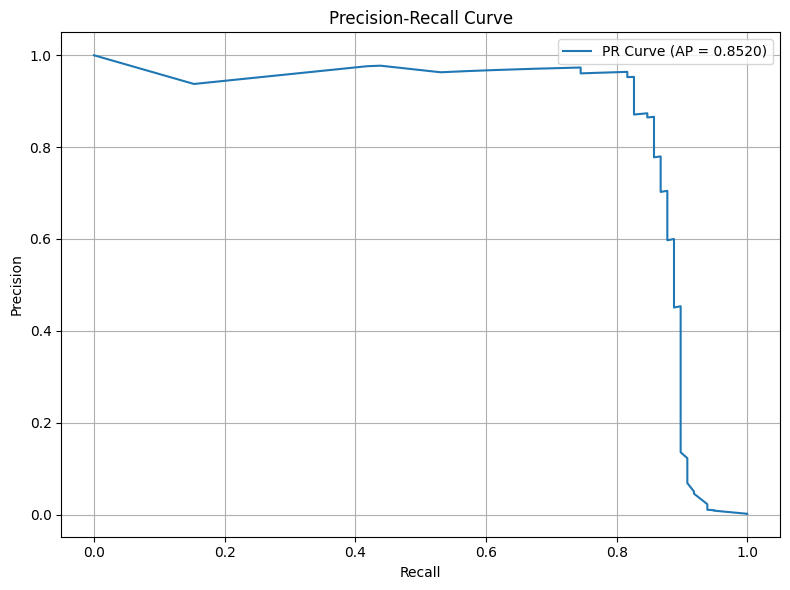

In [24]:
rf_pr_auc = average_precision_score(y_test, rf_y_proba)
display(f"PR AUC (Average Precision): {rf_pr_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, rf_y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {rf_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### RandomForest - Interpretação da Precision-Recall Curve

- O valor de **Average Precision (AP) é 0.8520**, o que indica uma performance sólida — o modelo consegue manter boa precisão mesmo enquanto aumenta o recall.
- A curva permanece com **alta precisão (acima de 0.95)** até aproximadamente **80% de recall**, sugerindo que o modelo é eficaz em identificar a maioria das fraudes sem gerar muitos falsos positivos.
- A partir de 80% de recall, a precisão começa a cair acentuadamente, evidenciando o **trade-off natural** entre aumentar a cobertura (recall) e manter a qualidade das predições (precisão).

O desempenho geral é bom, com o modelo equilibrando corretamente os dois objetivos em grande parte da curva. Isso o torna uma opção viável para cenários em que é preferível errar por excesso (investigar falsos positivos) a deixar passar fraudes reais.


📊 Classification Report Random Forest (validação):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.87      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



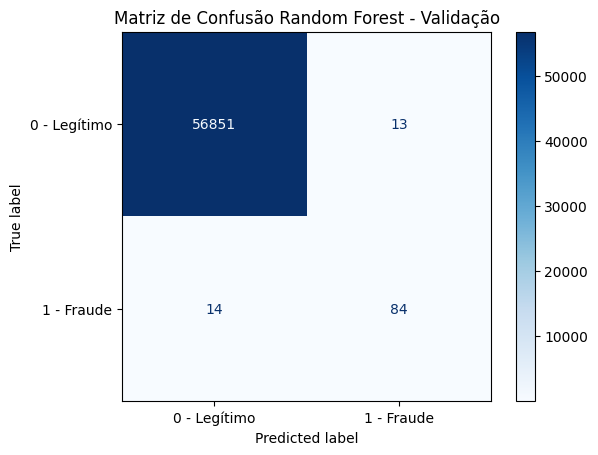

In [52]:
print("📊 Classification Report Random Forest (validação):")
print(classification_report(y_test, rf_y_pred))

val_cm = confusion_matrix(y_test, rf_y_pred)

val_disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=display_labels)
val_disp.plot(cmap='Blues')
plt.title("Matriz de Confusão Random Forest - Validação")
plt.show()

#### XGBClassifier

Melhores parâmetros: {'clf__learning_rate': None, 'clf__max_depth': 10, 'clf__scale_pos_weight': 10}

In [12]:
xgb_model_name = "fraud_pipeline_xgb-depth10-wscale10-powertransform-v1.joblib"
xgb_model_file = models_path / xgb_model_name

In [54]:
from xgboost import XGBClassifier

xgb_final = XGBClassifier(
    random_state=42, 
    n_estimators=50, 
    eval_metric="logloss",
    learning_rate=None,
    max_depth=10,
    scale_pos_weight=10,
)

xgb_pipeline = create_pipeline(xgb_final, preprocessor)

display(xgb_pipeline.fit(X_train, y_train))
joblib.dump(xgb_pipeline, xgb_model_file)

/home/rcalabro/codebase/senac-ia/machine-learning/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power', PowerTransformer(),
                                                  ['V28', 'Amount'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='log...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

['models/fraud_pipeline_xgb-depth10-wscale10-powertransform-v1.joblib']

In [13]:
xgb_pipeline = joblib.load(xgb_model_file)

/tmp/ipykernel_340666/952016526.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/rcalabro/codebase/senac-ia/machine-learning/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


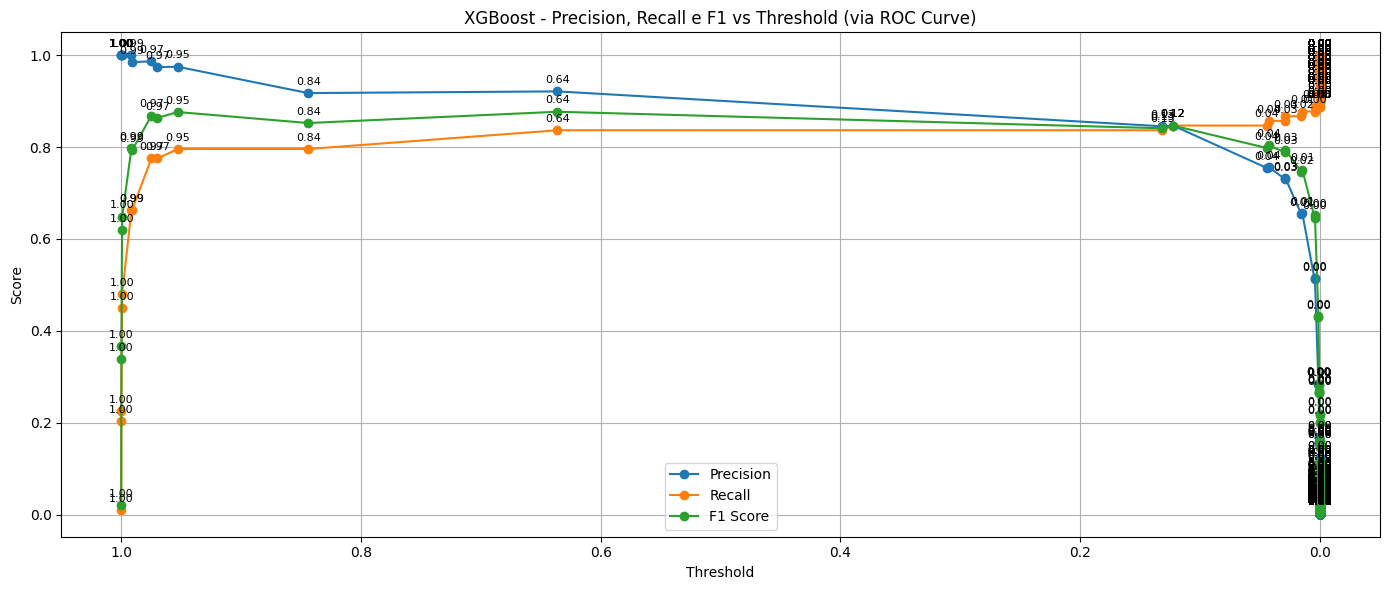

In [19]:
plot_threshold_metrics(xgb_pipeline, X_test, y_test, title_prefix="XGBoost - ")

In [15]:
xbg_threshold = 0.12 # análise visual
xgb_y_pred = predict_with_threshold(xgb_pipeline, X_test, xbg_threshold)
xgb_y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

'PR AUC (Average Precision): 0.8717'

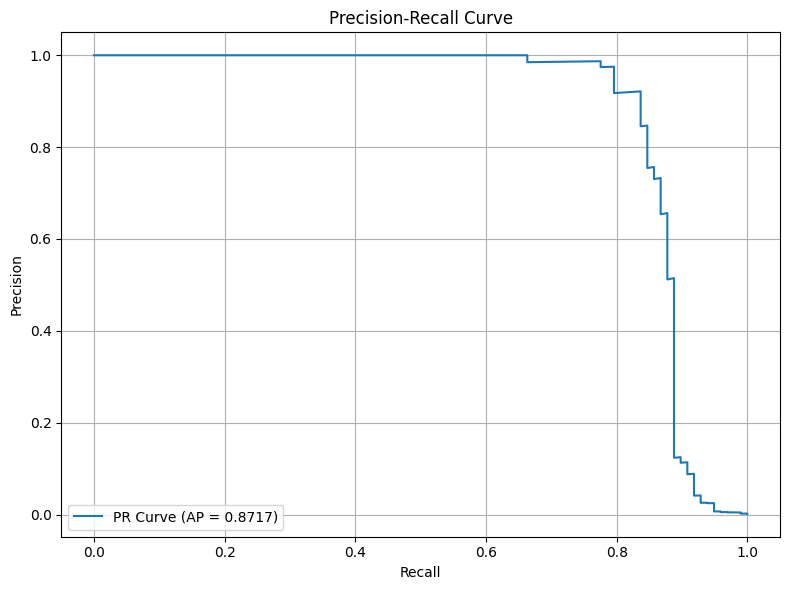

In [22]:
xgb_pr_auc = average_precision_score(y_test, xgb_y_proba)
display(f"PR AUC (Average Precision): {xgb_pr_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, xgb_y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {xgb_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### XGBClassifier - Interpretação da Precision-Recall Curve

- O modelo obteve um **Average Precision (AP) de 0.8717**, indicando alta capacidade de identificar transações fraudulentas mantendo boa precisão.
- A curva se mantém em níveis altos de **precisão** até aproximadamente 80% de **recall**, o que mostra que o modelo consegue detectar a maioria das fraudes sem gerar muitos falsos positivos.
- A partir de certo ponto, a precisão cai rapidamente à medida que o recall se aproxima de 1.0, evidenciando o trade-off natural entre detectar mais fraudes e manter a confiabilidade nas predições.

Esse resultado é bastante positivo e sugere que o modelo é eficaz em priorizar alertas com alta probabilidade de fraude.


📊 Classification Report XGBClassifier (validação):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.85      0.85      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



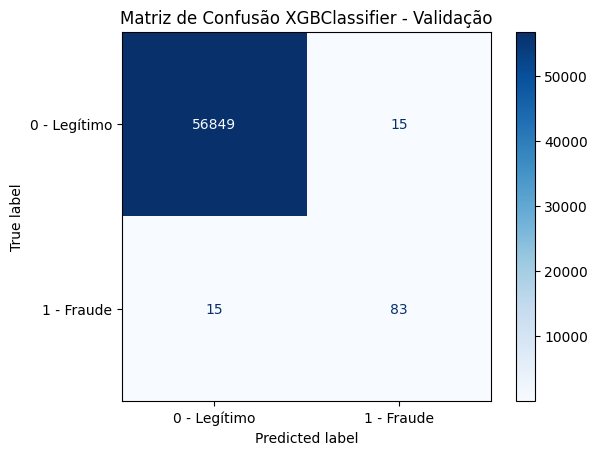

In [17]:
print("📊 Classification Report XGBClassifier (validação):")
print(classification_report(y_test, xgb_y_pred))

val_cm = confusion_matrix(y_test, xgb_y_pred)

val_disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=display_labels)
val_disp.plot(cmap='Blues')
plt.title("Matriz de Confusão XGBClassifier - Validação")
plt.show()


## Comparação Final dos Modelos com Threshold Ajustado (Fraude Financeira)

Ajustar o threshold de decisão é uma prática essencial em cenários de fraude financeira, onde o objetivo principal é **reduzir falsos negativos** — ou seja, minimizar a quantidade de fraudes que são classificadas como transações legítimas. Embora esse ajuste possa impactar ligeiramente a precisão (mais falsos positivos), ele é justificável pelo alto custo associado a fraudes não detectadas.


### Random Forest

- Falsos negativos (fraudes perdidas): 14  
- Falsos positivos (legítimos marcados como fraude): 13  
- Average Precision (AP) é 0.8520
- Melhor recall no grupo positivo.


### XGBoost

- Falsos negativos (fraudes perdidas): 15  
- Falsos positivos (legítimos marcados como fraude): 15  
- Average Precision (AP) de 0.8717  
- Melhor performance geral, mas perde levemente em recall comparado ao RF.


## Conclusão

Ambos os modelos performam muito bem, com excelente separação entre classes após ajuste do threshold. No entanto:

- Random Forest teve um recall ligeiramente melhor na classe de fraude, detectando uma fraude a mais.
- XGBoost teve melhor AUC ROC, mas com leve perda de recall.

Em contextos onde não detectar fraudes custa mais do que investigar falsos positivos, como neste caso, o Random Forest com threshold ajustado é ligeiramente mais seguro.
